In [35]:
# ============================================
# 1. Importación de librerías
# ============================================

import pandas as pd                
import numpy as np     
import matplotlib.pyplot as plt            

from sklearn.model_selection import train_test_split, GridSearchCV
# train_test_split separa los datos en entrenamiento y prueba
# GridSearchCV realiza una búsqueda exhaustiva de hiperparámetros

from sklearn.preprocessing import StandardScaler
# StandardScaler normaliza los datos (media=0, desviación=1)

from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier es el algoritmo clásico a implementar
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize



In [36]:
# ============================================
# 2. Cargar los dos archivos (datos + etiquetas)
# ============================================

# Cargar datos de expresión génica
X = pd.read_csv("data.csv")

# Cargar etiquetas
labels = pd.read_csv("labels.csv")



In [37]:
# ============================================
# 3. Arreglar índices y unir RNA-seq con etiquetas
# ============================================

# Arreglar nombre de columna en X
X = X.rename(columns={"Unnamed: 0": "sample"})
X = X.set_index("sample")

# Arreglar labels
labels = labels.rename(columns={labels.columns[0]: "sample", "Class": "type"})
labels = labels.set_index("sample")

# Unir ambas tablas por sample
df_data = X.join(labels)

print("Dimensionalidad de datos:", df_data.shape)
print("Categorías verdaderas únicas:", df_data.type.unique())
df_data.head()


Dimensionalidad de datos: (801, 20532)
Categorías verdaderas únicas: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,type
sample,,,,,,,,,,,,,,,,,,,,,
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


In [38]:
# ============================================
# 4. Separar variables predictoras (X) y etiquetas (y)
# ============================================

X = df_data.drop(columns=["type"])
y = df_data["type"]



In [52]:
print("Dimensionalidad de X:", X.shape)
print("Dimensionalidad de y:", y.shape)

Dimensionalidad de X: (801, 20531)
Dimensionalidad de y: (801,)


In [39]:
# ============================================
# 5. División en entrenamiento y prueba
# ============================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, #20% muestras para test, 80% para train
    random_state=42,
    stratify=y  # muy importante por clases desbalanceadas
)



In [40]:

# Imprimir dimensiones resultantes
print("=== Dimensionalidad después del split ===")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

# Verificar distribución estratificada
print("\nDistribución de clases en y:")
print(y.value_counts(normalize=True))

print("\nDistribución en y_train:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en y_test:")
print(y_test.value_counts(normalize=True))


=== Dimensionalidad después del split ===
X_train: (640, 20531)
X_test:  (161, 20531)
y_train: (640,)
y_test:  (161,)

Distribución de clases en y:
type
BRCA    0.374532
KIRC    0.182272
LUAD    0.176030
PRAD    0.169788
COAD    0.097378
Name: proportion, dtype: float64

Distribución en y_train:
type
BRCA    0.375000
KIRC    0.181250
LUAD    0.176563
PRAD    0.170313
COAD    0.096875
Name: proportion, dtype: float64

Distribución en y_test:
type
BRCA    0.372671
KIRC    0.186335
LUAD    0.173913
PRAD    0.167702
COAD    0.099379
Name: proportion, dtype: float64


Claramente BRCA es la clase dominante con ~37%.
COAD es la clase minoritaria (~10%).
Las otras 3 clases están bien distribuidas entre ~17–18%.

Todo el proceso de split produjo:
Un conjunto de entrenamiento y prueba con tamaños adecuados.
Proporciones de clases preservadas gracias a la estratificación.
Ninguna clase quedó subrepresentada, incluso la minoritaria COAD

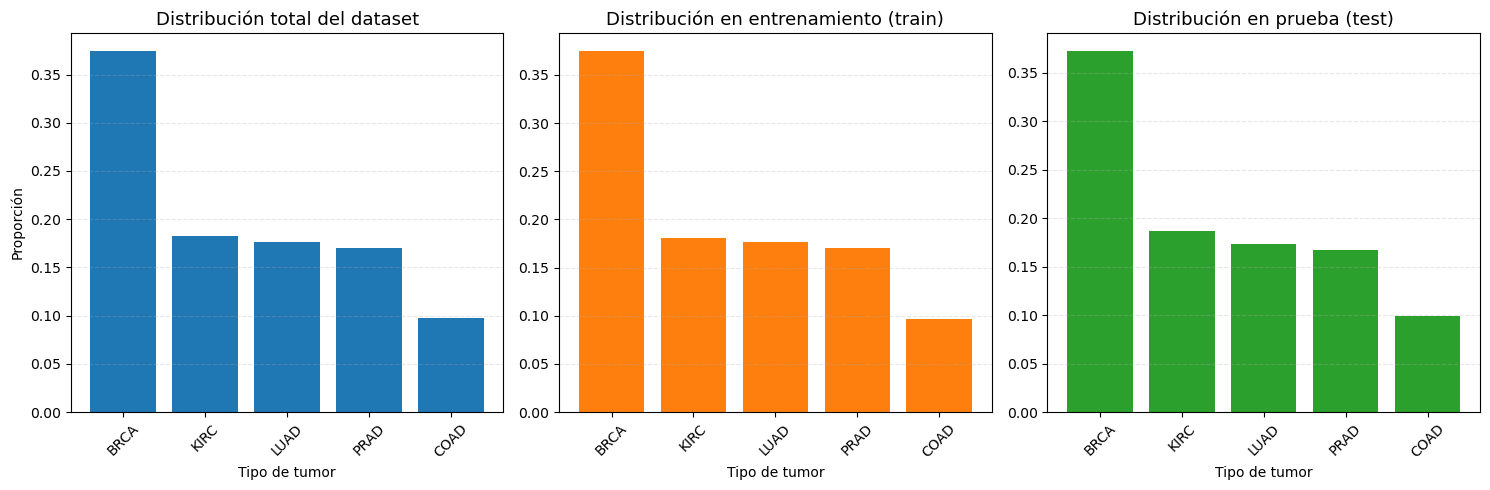

In [41]:
# ============================================
# Barplots de distribución de clases 
# ============================================

# Proporciones
prop_total = y.value_counts(normalize=True)
prop_train = y_train.value_counts(normalize=True)
prop_test = y_test.value_counts(normalize=True)

# Orden uniforme de clases
class_order = prop_total.index

# Colores profesionales para cada gráfica
color_total = "#1f77b4"   # azul
color_train = "#ff7f0e"   # naranja
color_test  = "#2ca02c"   # verde

# Crear figura
plt.figure(figsize=(15, 5))

# ---- Total ----
plt.subplot(1, 3, 1)
plt.bar(class_order, prop_total[class_order], color=color_total)
plt.title("Distribución total del dataset", fontsize=13)
plt.xlabel("Tipo de tumor")
plt.ylabel("Proporción")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# ---- Train ----
plt.subplot(1, 3, 2)
plt.bar(class_order, prop_train[class_order], color=color_train)
plt.title("Distribución en entrenamiento (train)", fontsize=13)
plt.xlabel("Tipo de tumor")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# ---- Test ----
plt.subplot(1, 3, 3)
plt.bar(class_order, prop_test[class_order], color=color_test)
plt.title("Distribución en prueba (test)", fontsize=13)
plt.xlabel("Tipo de tumor")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


Figura SX. Distribución de los tipos de tumor en el conjunto de datos.
( a ) Proporción de muestras para cada tipo de tumor (BRCA, KIRC, LUAD, PRAD y COAD) en el conjunto total del estudio.
( b ) Distribución de clases en el conjunto de entrenamiento (train) después del split estratificado, mostrando que se conserva la misma representación relativa de cada tumor.
( c ) Distribución de clases en el conjunto de prueba (test), donde también se mantiene la proporción original. En los tres paneles se observa que BRCA es la clase predominante (~37%), seguido por KIRC, LUAD y PRAD con proporciones similares (~17–18%), y COAD como la clase menos representada (~10%). Esta concordancia entre los tres conjuntos confirma que la división estratificada preservó adecuadamente la frecuencia de cada clase.

In [42]:
# ============================================
# 6. Normalización
# ============================================

scaler = StandardScaler()

# Ajustar solo con entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar X_test sin ajustar
X_test_scaled = scaler.transform(X_test)


La matriz de expresión génica contiene 20,531 genes con valores en diferentes escalas.
Para evitar que genes con valores muy altos dominen el entrenamiento del modelo, realizamos una normalización tipo Z-score (StandardScaler).
Este procedimiento es el estándar para modelos de aprendizaje clásico como Random Forest, SVM y Logistic Regression, y garantiza que todas las características estén en la misma escala, mejorando la estabilidad y desempeño del modelo.

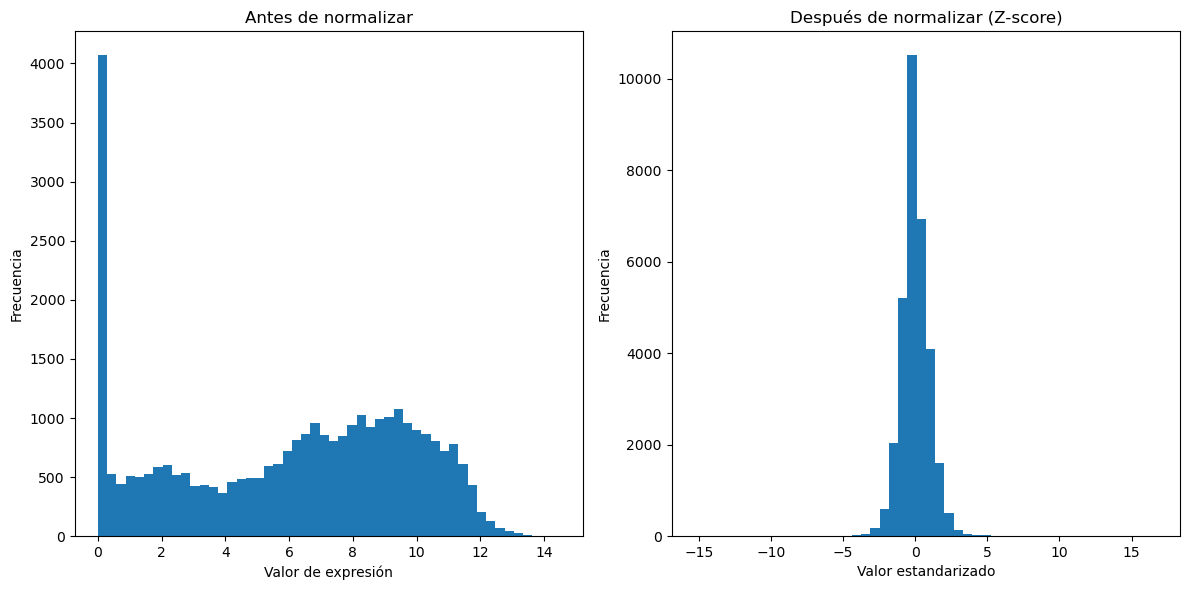

In [43]:
# ============================================
# Seleccionar 50 genes aleatorios para visualizar
# ============================================

np.random.seed(42)
genes_sample = np.random.choice(X_train.columns, size=50, replace=False)

# Extraer valores antes y después
before_norm = X_train[genes_sample].values.flatten()
after_norm  = pd.DataFrame(X_train_scaled, columns=X_train.columns)[genes_sample].values.flatten()

# ============================================
# Graficar distribución antes y después
# ============================================

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.hist(before_norm, bins=50)
plt.title("Antes de normalizar")
plt.xlabel("Valor de expresión")
plt.ylabel("Frecuencia")

plt.subplot(1,2,2)
plt.hist(after_norm, bins=50)
plt.title("Después de normalizar (Z-score)")
plt.xlabel("Valor estandarizado")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


Figura SX. Efecto de la normalización Z-score sobre la distribución de los valores de expresión génica.
(A) Distribución original de los valores de expresión, caracterizada por rangos amplios y asimetría debido a diferencias en la intensidad de expresión entre genes.
(B) Distribución tras la normalización utilizando StandardScaler, donde los valores se centran en una media de 0 y se escalan a una desviación estándar de 1. Esto homogeniza la escala de todas las características y evita que genes con mayor magnitud dominen el entrenamiento del modelo de aprendizaje automático.

In [44]:
# ============================================
# 7. Random Forest + GridSearchCV
# ============================================

# El argumento random_state asegura reproducibilidad en la generación de los árboles.
rf = RandomForestClassifier(random_state=42)

# Definición del grid de hiperparámetros a evaluar con GridSearchCV.
param_grid = {
    # n_estimators: número de árboles en el bosque.
    # Más árboles suelen mejorar estabilidad, pero incrementan el costo computacional.
    "n_estimators": [100, 200],

    # max_depth: profundidad máxima permitida para cada árbol.
    # Limitarla controla el sobreajuste; valores mayores permiten árboles más complejos.
    "max_depth": [10, 20],

    # max_features: número de características a considerar al buscar la mejor división.
    # "sqrt": usa la raíz cuadrada del número total de variables.
    # "log2": usa el logaritmo base 2 del total de variables.
    # Este hiperparámetro controla la aleatoriedad y la diversidad entre árboles.
    "max_features": ["sqrt", "log2"],

    # min_samples_split: número mínimo de muestras requerido para dividir un nodo.
    # Valores pequeños permiten capturar patrones más finos, pero aumentan el riesgo de sobreajuste.
    "min_samples_split": [2, 5]
}

# Configuración del GridSearchCV:
# - rf: el modelo base que se ajustará con diferentes hiperparámetros.
# - param_grid: las combinaciones de hiperparámetros a explorar.
# - cv=5: validación cruzada de 5 particiones para evaluar cada combinación.
# - scoring="f1_macro": métrica de evaluación apropiada para clases desbalanceadas.
# - n_jobs=-1: usa todos los núcleos disponibles para acelerar el proceso.
# - verbose=2: muestra información detallada durante la ejecución.
grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="f1_macro",  # métrica principal para clases desbalanceadas
    n_jobs=-1,
    verbose=2
)

# Ajuste del modelo: entrena Random Forest probando todas las combinaciones
# del grid y seleccionando la mejor según la métrica F1-macro.
grid.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[CV] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, max_features=log2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=100; total time=   0.8s


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [45]:
# ============================================
# 8. Análisis de resultados de GridSearchCV
# ============================================

print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)

print("\nMejor F1-macro promedio (CV=5):")
print(grid.best_score_)

Mejores hiperparámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}

Mejor F1-macro promedio (CV=5):
0.9973561362849303


La optimización de hiperparámetros se realizó mediante GridSearchCV con validación cruzada estratificada de 5 particiones (5-fold CV), empleando F1-macro como métrica de evaluación. El mejor modelo alcanzó un F1-macro promedio de 0.997, estimado a partir de dichas particiones.

In [46]:
# ============================================
# 9. Mejor Modelo obtenido por GridSearchCV
# ============================================

best_model = grid.best_estimator_
best_model


,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [47]:
# ============================================
# 10. Extraer el mejor modelo y predecir
# ============================================

best_model = grid.best_estimator_

print("Mejor modelo encontrado:")
print(best_model)

# Predicciones en test
pred_y = best_model.predict(X_test_scaled)
proba_y = best_model.predict_proba(X_test_scaled)


Mejor modelo encontrado:
RandomForestClassifier(max_depth=10, random_state=42)


In [48]:
# ============================================
# 11. Métricas finales en TEST
# ============================================

from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    matthews_corrcoef, roc_auc_score
)

results = {
    "F1 (weighted)": f1_score(y_test, pred_y, average="weighted"),
    "Precision (weighted)": precision_score(y_test, pred_y, average="weighted"),
    "Recall (weighted)": recall_score(y_test, pred_y, average="weighted"),
    "MCC": matthews_corrcoef(y_test, pred_y),
    "AUC (weighted/OVR)": roc_auc_score(
        y_test,
        proba_y,
        multi_class="ovr",
        average="weighted"
    )
}

print("\n===== Métricas finales en TEST =====")
for key, value in results.items():
    print(f"{key}: {value:.4f}")



===== Métricas finales en TEST =====
F1 (weighted): 0.9874
Precision (weighted): 0.9880
Recall (weighted): 0.9876
MCC: 0.9838
AUC (weighted/OVR): 1.0000


<Figure size 700x600 with 0 Axes>

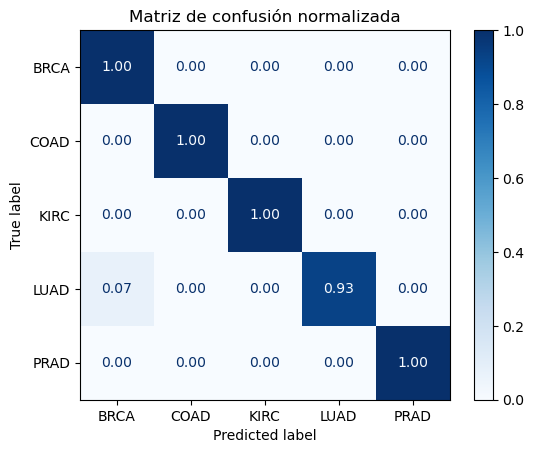


===== Reporte de clasificación =====
              precision    recall  f1-score   support

        BRCA       0.97      1.00      0.98        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      0.93      0.96        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



In [49]:
# ============================================
# 12. Matriz de confusión y clasificación
# ============================================

# Matriz de confusión
cm = confusion_matrix(y_test, pred_y, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
plt.figure(figsize=(7, 6))
disp.plot(cmap='Blues', values_format='.2f')
plt.title("Matriz de confusión normalizada")
plt.show()

# Reporte de clasificación
print("\n===== Reporte de clasificación =====")
print(classification_report(y_test, pred_y))


El classification report muestra un desempeño casi perfecto en todas las clases, con F1-scores de 0.98–1.00, excepto para LUAD, donde el recall baja ligeramente a 0.93, indicando que el modelo omite una pequeña fracción de casos de esta clase. COAD, KIRC y PRAD se clasifican sin errores en el test (precision, recall y F1 = 1.00), mientras que BRCA presenta precisión de 0.97 y recall de 1.00. A nivel global, el modelo alcanza una accuracy de 0.99 y promedios macro y ponderado de F1 de 0.99, lo que refleja un rendimiento muy alto y equilibrado en un escenario multiclase desbalanceado.

In [50]:
# ============================================
# 13. Guardar resultados y grid completa
# ============================================

df_grid = pd.DataFrame(grid.cv_results_)
df_grid.to_csv("GridSearchCV_RandomForest_Resultados_Completos.csv", index=False)

pd.DataFrame([results]).to_csv("RandomForest_Metricas_Finales.csv", index=False)

print("Archivos guardados:")
print(" - GridSearchCV_RandomForest_Resultados_Completos.csv")
print(" - RandomForest_Metricas_Finales.csv")


Archivos guardados:
 - GridSearchCV_RandomForest_Resultados_Completos.csv
 - RandomForest_Metricas_Finales.csv


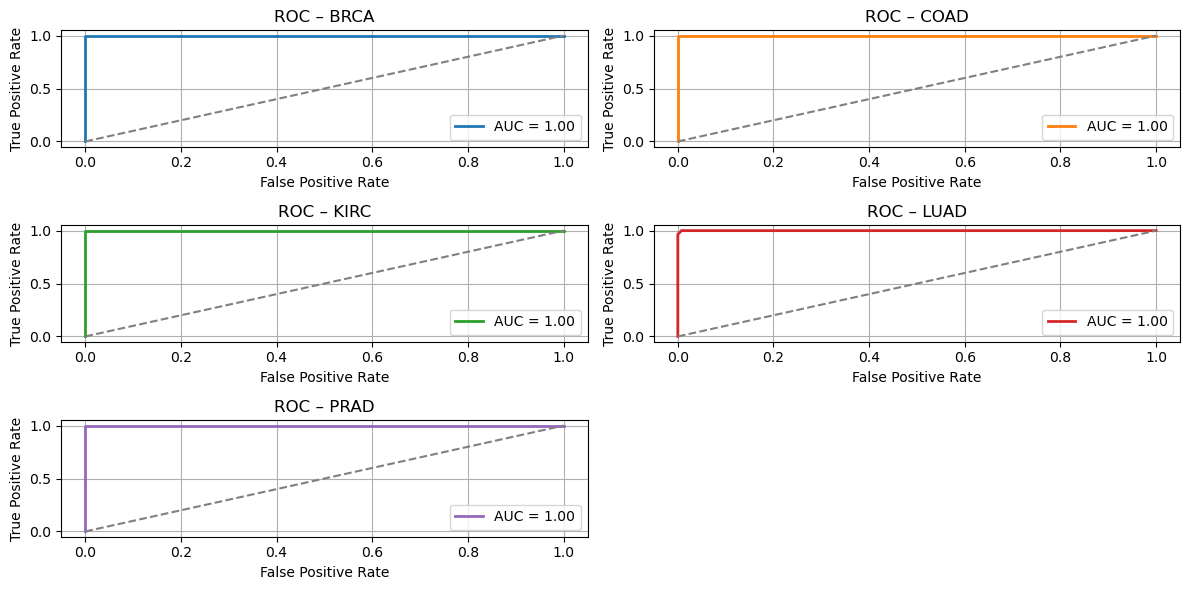

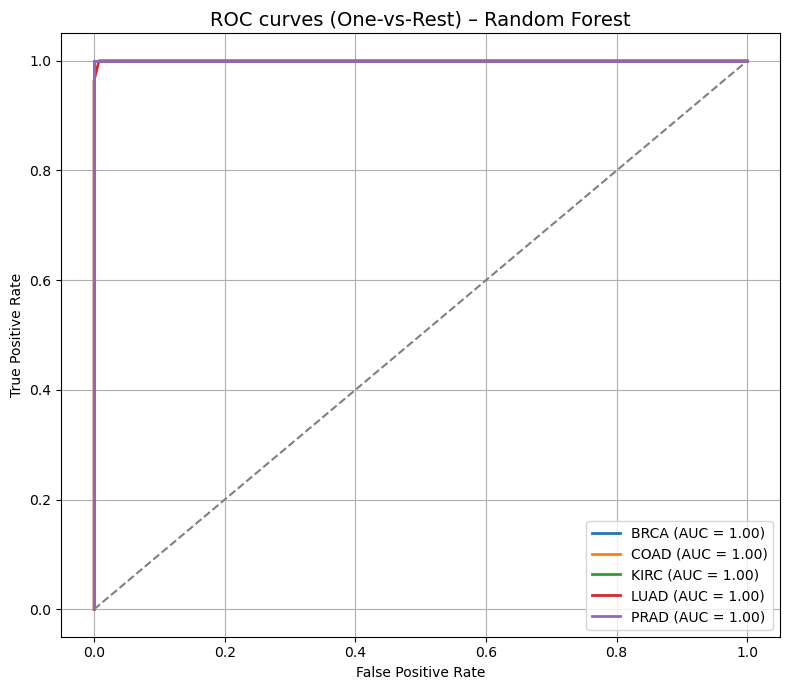

In [51]:

# ============================================
# 14. Generar curvas ROC
# ============================================
# Paleta de colores
frontiers_colors = [
    "#1f77b4",  
    "#ff7f0e",  
    "#2ca02c",
    "#d62728",  
    "#9467bd", 
    "#8c564b", 
    "#e377c2", 
    "#7f7f7f",  
    "#bcbd22", 
    "#17becf"  
]

# Binarizar etiquetas
classes = best_model.classes_
y_test_bin = label_binarize(y_test, classes=classes)

n_classes = len(classes)

# Asegurar que hay suficientes colores
colors = frontiers_colors[:n_classes]

# ============================================================
# 1. SUBPLOTS por clase
# ============================================================

fig, axes = plt.subplots(
    nrows=np.ceil(n_classes / 2).astype(int),
    ncols=2,
    figsize=(12, 6)
)
axes = axes.flatten()

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba_y[:, i])
    roc_auc = auc(fpr, tpr)

    ax = axes[i]
    ax.plot(
        fpr, tpr, lw=2, color=colors[i],
        label=f"AUC = {roc_auc:.2f}"
    )
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

    ax.set_title(f"ROC – {cls}", fontsize=12)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

# Eliminar paneles vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# ============================================================
# 2. PLOT con todas las curvas ROC juntas
# ============================================================

plt.figure(figsize=(8, 7))

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba_y[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr, tpr, lw=2, color=colors[i],
        label=f"{cls} (AUC = {roc_auc:.2f})"
    )

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC curves (One-vs-Rest) – Random Forest", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
